# Figure 1

In [120]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import xcdat as xc
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm as BM
import pandas as pd
import matplotlib as mpl
import matplotlib.ticker as mticker
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 2.0
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

In [4]:
best_loc = './data/tas/Berkeley_Earth_Land_and_Ocean_LatLong1.nc'
best = xr.open_dataset(best_loc)
best

<xarray.Dataset>
Dimensions:      (longitude: 360, latitude: 180, time: 2084, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) float64 1.85e+03 1.85e+03 ... 2.024e+03 2.024e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 ...
    temperature  (time, latitude, longitude) float32 ...
    climatology  (month_number, latitude, longitude) float32 ...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               16-Sep-2023 07:12:12
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   04-Sep-2023 07:26:43
    ocean_source_history:  16-Sep-2023 05:22:22
    comment:               This file contains Berkeley Earth surface temperat...

In [5]:
#use population data as mask
pop_2020 = xc.open_dataset('./data/population/gpw_gridded_population_2020.nc', lon_orient=(-180, 180)).Band1
pop_2020

2024-04-22 15:33:38,685 [WARNING]: dataset.py(open_dataset:109) >> "No time coordinates were found in this dataset to decode. If time coordinates were expected to exist, make sure they are detectable by setting the CF 'axis' or 'standard_name' attribute (e.g., ds['time'].attrs['axis'] = 'T' or ds['time'].attrs['standard_name'] = 'time'). Afterwards, try decoding again with `xcdat.decode_time`."


<xarray.DataArray 'Band1' (lat: 180, lon: 360)>
[64800 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:           GDAL Band Number 1
    RepresentationType:  ATHEMATIC
    grid_mapping:        crs

In [6]:
best = best.rename(dict(latitude = 'lat', longitude = 'lon'))
best['time'] = pd.date_range(start='1850-01-01', end='2023-08-31', freq='1M')
best['lat'] = pop_2020.lat
best['lon'] = pop_2020.lon
best

<xarray.Dataset>
Dimensions:      (lon: 360, lat: 180, time: 2084, month_number: 12)
Coordinates:
  * lon          (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time         (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2023-08-31
Dimensions without coordinates: month_number
Data variables:
    land_mask    (lat, lon) float64 ...
    temperature  (time, lat, lon) float32 ...
    climatology  (month_number, lat, lon) float32 ...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               16-Sep-2023 07:12:12
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   04-Sep-2023 07:26:43
    ocean_source_history:  16-Sep-2023 05:22:22
    comment:               This file contains Berkeley Earth surface temperat...

In [7]:
from functions import preprocess_temp
from functions import trend_analysis

In [8]:
best_gmst = preprocess_temp.calc_gmst(best.temperature)
best_gmst_land = preprocess_temp.calc_gmst(best.temperature.where(~pop_2020.isnull()))
best_smooth_gmst = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(best_gmst), year = best_gmst['year'].to_numpy())).set_index('year').to_xarray().temp_smooth
best_smooth_gmst_land = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(best_gmst_land), year = best_gmst_land['year'].to_numpy())).set_index('year').to_xarray().temp_smooth

In [9]:
best_smooth_gmst

<xarray.DataArray 'temp_smooth' (year: 174)>
array([-2.90672930e-01, -2.90476567e-01, -2.90278902e-01, -2.90079746e-01,
       -2.89878897e-01, -2.89676653e-01, -2.89474324e-01, -2.89274050e-01,
       -2.89078463e-01, -2.88890589e-01, -2.88713308e-01, -2.88549182e-01,
       -2.88400840e-01, -2.88270613e-01, -2.88160497e-01, -2.88072647e-01,
       -2.88009142e-01, -2.87971598e-01, -2.87960680e-01, -2.87976407e-01,
       -2.88018798e-01, -2.88087153e-01, -2.88178700e-01, -2.88287943e-01,
       -2.88406617e-01, -2.88523589e-01, -2.88622689e-01, -2.88678165e-01,
       -2.88648587e-01, -2.88474636e-01, -2.88606338e-01, -2.88822076e-01,
       -2.89206230e-01, -2.89846724e-01, -2.90825149e-01, -2.92199623e-01,
       -2.93993691e-01, -2.96182552e-01, -2.98699354e-01, -3.01468818e-01,
       -3.04430563e-01, -3.07525501e-01, -3.10692417e-01, -3.13858990e-01,
       -3.16942811e-01, -3.19861594e-01, -3.22542581e-01, -3.24923618e-01,
       -3.26945371e-01, -3.28538602e-01, -3.29645175e-01, -3.30235709e-01,
       -3.30323118e-01, -3.29935710e-01, -3.29094594e-01, -3.27816341e-01,
       -3.26133739e-01, -3.24093798e-01, -3.21751029e-01, -3.19142481e-01,
       -3.16276597e-01, -3.13135215e-01, -3.09665215e-01, -3.05777049e-01,
       -3.01363448e-01, -2.96334695e-01, -2.90631227e-01, -2.84213035e-01,
       -2.77065705e-01, -2.69190678e-01, -2.60600138e-01, -2.51339057e-01,
       -2.41485588e-01, -2.31143893e-01, -2.20427669e-01, -2.09438673e-01,
       -1.98269775e-01, -1.87017609e-01, -1.75796610e-01, -1.64752864e-01,
...
       -4.31540684e-02, -3.92753949e-02, -3.57515707e-02, -3.26082764e-02,
       -2.98494506e-02, -2.74456283e-02, -2.53376744e-02, -2.34447091e-02,
       -2.16826671e-02, -1.99791837e-02, -1.82571756e-02, -1.64301127e-02,
       -1.44166492e-02, -1.21418504e-02, -9.54204449e-03, -6.55475990e-03,
       -3.11756246e-03,  8.42372763e-04,  5.39013733e-03,  1.05747656e-02,
        1.64215173e-02,  2.29468452e-02,  3.01627658e-02,  3.80689155e-02,
        4.66583122e-02,  5.59236714e-02,  6.58410181e-02,  7.63731551e-02,
        8.74874042e-02,  9.91696124e-02,  1.11415230e-01,  1.24235536e-01,
        1.37663677e-01,  1.51734078e-01,  1.66452565e-01,  1.81788258e-01,
        1.97685967e-01,  2.14086684e-01,  2.30939412e-01,  2.48200600e-01,
        2.65821327e-01,  2.83743954e-01,  3.01923104e-01,  3.20330714e-01,
        3.38941449e-01,  3.57714528e-01,  3.76605356e-01,  3.95575322e-01,
        4.14604962e-01,  4.33794036e-01,  4.53134927e-01,  4.72590579e-01,
        4.92124211e-01,  5.11710579e-01,  5.31332991e-01,  5.50981654e-01,
        5.70650730e-01,  5.90335622e-01,  6.10032521e-01,  6.29738665e-01,
        6.49451617e-01,  6.69168710e-01,  6.88887309e-01,  7.08605939e-01,
        7.28323935e-01,  7.48041083e-01,  7.67757902e-01,  7.87475916e-01,
        8.07197221e-01,  8.26924623e-01,  8.46660714e-01,  8.66407021e-01,
        8.86163771e-01,  9.05931024e-01,  9.25709243e-01,  9.45498691e-01,
        9.65299692e-01,  9.85112975e-01])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2019 2020 2021 2022 2023

In [10]:
best_smooth_gmst_land

<xarray.DataArray 'temp_smooth' (year: 174)>
array([-4.73323066e-01, -4.71133949e-01, -4.68927573e-01, -4.66702217e-01,
       -4.64455891e-01, -4.62187375e-01, -4.59897089e-01, -4.57586395e-01,
       -4.55257244e-01, -4.52912176e-01, -4.50554194e-01, -4.48186357e-01,
       -4.45811840e-01, -4.43433589e-01, -4.41053729e-01, -4.38674994e-01,
       -4.36299978e-01, -4.33930979e-01, -4.31569777e-01, -4.29218073e-01,
       -4.26877950e-01, -4.24551679e-01, -4.22239769e-01, -4.19939554e-01,
       -4.17645365e-01, -4.15348112e-01, -4.13031476e-01, -4.10659506e-01,
       -4.08157078e-01, -4.05395138e-01, -4.01704474e-01, -3.97931112e-01,
       -3.94184572e-01, -3.90568875e-01, -3.87180366e-01, -3.84085029e-01,
       -3.81306039e-01, -3.78807686e-01, -3.76513504e-01, -3.74350513e-01,
       -3.72280462e-01, -3.70287063e-01, -3.68350554e-01, -3.66436010e-01,
       -3.64478150e-01, -3.62403926e-01, -3.60153619e-01, -3.57668835e-01,
       -3.54883398e-01, -3.51710703e-01, -3.48074462e-01, -3.43939363e-01,
       -3.39347241e-01, -3.34372931e-01, -3.29085401e-01, -3.23544148e-01,
       -3.17834825e-01, -3.12057177e-01, -3.06299388e-01, -3.00607354e-01,
       -2.94982491e-01, -2.89391462e-01, -2.83761364e-01, -2.77979574e-01,
       -2.71917103e-01, -2.65473815e-01, -2.58596780e-01, -2.51260305e-01,
       -2.43466242e-01, -2.35209381e-01, -2.26467908e-01, -2.17231130e-01,
       -2.07529602e-01, -1.97429260e-01, -1.87024862e-01, -1.76399658e-01,
       -1.65626801e-01, -1.54794218e-01, -1.44026514e-01, -1.33505811e-01,
...
       -2.52543547e-02, -2.20955291e-02, -1.92643315e-02, -1.67878197e-02,
       -1.46946432e-02, -1.29845007e-02, -1.16146124e-02, -1.05073909e-02,
       -9.57219743e-03, -8.72992867e-03, -7.89206116e-03, -6.95547468e-03,
       -5.81827612e-03, -4.37442771e-03, -2.53272947e-03, -1.98380778e-04,
        2.72609592e-03,  6.34383809e-03,  1.07223671e-02,  1.58912474e-02,
        2.18550860e-02,  2.86207972e-02,  3.62048061e-02,  4.46188753e-02,
        5.38788768e-02,  6.40139050e-02,  7.50423720e-02,  8.69728240e-02,
        9.98130308e-02,  1.13578689e-01,  1.28259866e-01,  1.43853836e-01,
        1.60390388e-01,  1.77926244e-01,  1.96498153e-01,  2.16095973e-01,
        2.36673684e-01,  2.58174063e-01,  2.80544144e-01,  3.03744047e-01,
        3.27730347e-01,  3.52439311e-01,  3.77809133e-01,  4.03791449e-01,
        4.30330905e-01,  4.57332290e-01,  4.84684150e-01,  5.12298071e-01,
        5.40133744e-01,  5.68909641e-01,  5.97875723e-01,  6.26991022e-01,
        6.56215860e-01,  6.85525201e-01,  7.14902391e-01,  7.44336697e-01,
        7.73821189e-01,  8.03349763e-01,  8.32916306e-01,  8.62516115e-01,
        8.92144651e-01,  9.21797042e-01,  9.51468113e-01,  9.81153988e-01,
        1.01085206e+00,  1.04056049e+00,  1.07027820e+00,  1.10000584e+00,
        1.12974485e+00,  1.15949792e+00,  1.18926733e+00,  1.21905372e+00,
        1.24885589e+00,  1.27867252e+00,  1.30850364e+00,  1.33834962e+00,
        1.36821093e+00,  1.39808812e+00])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2019 2020 2021 2022 2023

In [11]:
sy, ey, slope, pval, duration = trend_analysis.get_all_trends(best_smooth_gmst, initial_dur=30)

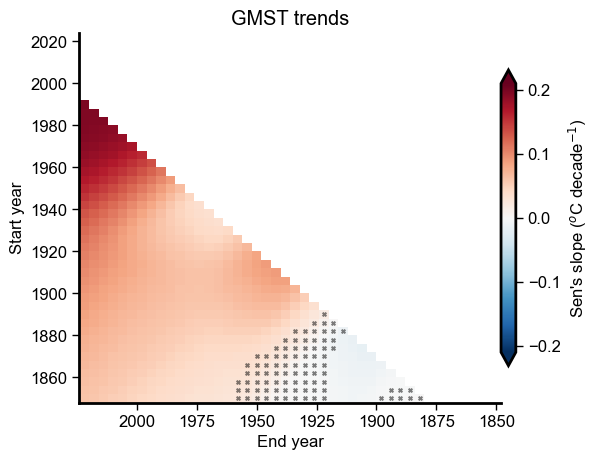

In [12]:
x, y = np.meshgrid(ey, sy)
cf =  plt.pcolormesh(x, y, slope, cmap='RdBu_r', vmin=-0.21, vmax=0.21)
plt.scatter(x[pval > 0.05], y[pval > 0.05], color='k', marker='x', s=7, alpha=0.5)
zm = np.ma.masked_less(pval, 0.05)
# plt.pcolor(x, y, zm, hatch='//', alpha=0.)
plt.colorbar(cf, shrink=0.8, pad=0., extend='both', label="Sen's slope ($^{o}$C decade$^{-1}$)")
plt.gca().invert_xaxis()
plt.ylabel('Start year')
plt.xlabel('End year')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('GMST trends')
plt.savefig('./images/trends/gmst_all_trends.png', dpi=300, bbox_inches='tight')

In [13]:
sy, ey, slope, pval, duration = trend_analysis.get_all_trends(best_smooth_gmst_land, initial_dur=30)

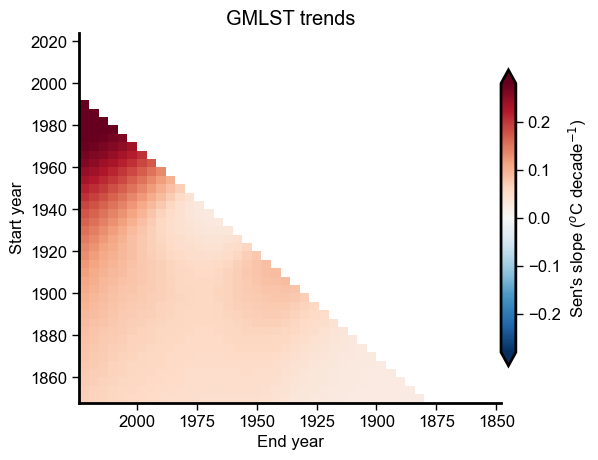

In [14]:
x, y = np.meshgrid(ey, sy)
cf =  plt.pcolormesh(x, y, slope, cmap='RdBu_r', vmin=-0.28, vmax=0.28)
plt.scatter(x[pval > 0.05], y[pval > 0.05], color='k', marker='x', s=7, alpha=0.5)
zm = np.ma.masked_less(pval, 0.05)
# plt.pcolor(x, y, zm, hatch='//', alpha=0.)
plt.colorbar(cf, shrink=0.8, pad=0., extend='both', label="Sen's slope ($^{o}$C decade$^{-1}$)")
plt.gca().invert_xaxis()
plt.ylabel('Start year')
plt.xlabel('End year')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('GMLST trends')
plt.savefig('./images/trends/gmst_all_trends_land.png', dpi=300, bbox_inches='tight')

In [15]:
# best_smooth = preprocess_temp.loess3d(best.temperature.ffill('time').bfill('time').groupby('time.year').mean('time'), dim='year')
# best_smooth

In [24]:
# best_smooth.to_netcdf('./data/results/best_smooth_temp.nc')
best_smooth = xr.open_dataset('./data/results/best_smooth_temp.nc').temperature
best_smooth

<xarray.DataArray 'temperature' (lat: 180, lon: 360, year: 174)>
[11275200 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2019 2020 2021 2022 2023

In [17]:
# trend_1850_1950 = trend_analysis.calc_trend3d(best_smooth.sel(year = slice('1850', '1950')), dim='year')
# trend_1850_1950_pval = trend_analysis.calc_trend_pval3d(best_smooth.sel(year = slice('1850', '1950')), dim='year')

In [19]:
trend_1890_1990 = trend_analysis.calc_trend3d(best_smooth.sel(year = slice('1890', '1990')), dim='year')
trend_1890_1990_pval = trend_analysis.calc_trend_pval3d(best_smooth.sel(year = slice('1890', '1990')), dim='year')

In [ ]:
trend_1920_2020 = trend_analysis.calc_trend3d(best_smooth.sel(year = slice('1920', '2020')), dim='year')
trend_1920_2020_pval = trend_analysis.calc_trend_pval3d(best_smooth.sel(year = slice('1920', '2020')), dim='year')

In [88]:
# trend_overall = trend_analysis.calc_trend3d(best_smooth, dim='year')
# trend_overall_pval = trend_analysis.calc_trend_pval3d(best_smooth, dim='year')

In [22]:
# trend_1850_1950.to_netcdf('./data/results/trends/trend_1850_1950.nc')
# trend_1850_1950_pval.to_netcdf('./data/results/trends/trend_1850_1950_pval.nc')

# trend_1880_1980.to_netcdf('./data/results/trends/trend_1880_1980.nc')
# trend_1880_1980_pval.to_netcdf('./data/results/trends/trend_1880_1980_pval.nc')

trend_1890_1990.to_netcdf('./data/results/trends/trend_1890_1990.nc')
trend_1890_1990_pval.to_netcdf('./data/results/trends/trend_1890_1990_pval.nc')


trend_1920_2020.to_netcdf('./data/results/trends/trend_1920_2020.nc')
trend_1920_2020_pval.to_netcdf('./data/results/trends/trend_1920_2020_pval.nc')

# trend_1920_2022.to_netcdf('./data/results/trends/trend_1920_2022.nc')
# trend_1920_2022_pval.to_netcdf('./data/results/trends/trend_1920_2022_pval.nc')

# trend_overall.to_netcdf('./data/results/trends/trend_overall.nc')
# trend_overall_pval.to_netcdf('./data/results/trends/trend_overall_pval.nc')

In [20]:
trend1 = xr.open_dataset('./data/results/trends/trend_1850_1950.nc').temperature
trend1_pval = xr.open_dataset('./data/results/trends/trend_1850_1950_pval.nc').temperature

trend2 = xr.open_dataset('./data/results/trends/trend_1890_1990.nc').temperature
trend2_pval = xr.open_dataset('./data/results/trends/trend_1890_1990_pval.nc').temperature

trend3 = xr.open_dataset('./data/results/trends/trend_1920_2020.nc').temperature
trend3_pval = xr.open_dataset('./data/results/trends/trend_1920_2020_pval.nc').temperature

trend4 = xr.open_dataset('./data/results/trends/trend_overall.nc').temperature
trend4_pval = xr.open_dataset('./data/results/trends/trend_overall_pval.nc').temperature

In [21]:
trend1['lat'] = pop_2020.lat
trend1['lon'] = pop_2020.lon
trend1_pval['lat'] = pop_2020.lat
trend1_pval['lon'] = pop_2020.lon
trend1_land = trend1.where(~pop_2020.isnull())
trend1_pval_land = trend1_pval.where(~pop_2020.isnull())


trend2['lat'] = pop_2020.lat
trend2['lon'] = pop_2020.lon
trend2_pval['lat'] = pop_2020.lat
trend2_pval['lon'] = pop_2020.lon
trend2_land = trend2.where(~pop_2020.isnull())
trend2_pval_land = trend2_pval.where(~pop_2020.isnull())

trend3['lat'] = pop_2020.lat
trend3['lon'] = pop_2020.lon
trend3_pval['lat'] = pop_2020.lat
trend3_pval['lon'] = pop_2020.lon
trend3_land = trend3.where(~pop_2020.isnull())
trend3_pval_land = trend3_pval.where(~pop_2020.isnull())

trend4['lat'] = pop_2020.lat
trend4['lon'] = pop_2020.lon
trend4_pval['lat'] = pop_2020.lat
trend4_pval['lon'] = pop_2020.lon
trend4_land = trend4.where(~pop_2020.isnull())
trend4_pval_land = trend4_pval.where(~pop_2020.isnull())

In [22]:
trend3.quantile(0.001)

<xarray.DataArray 'temperature' ()>
array(-0.492157)
Coordinates:
    quantile  float64 0.001

In [26]:
import seaborn as sns

<Axes: ylabel='Density'>

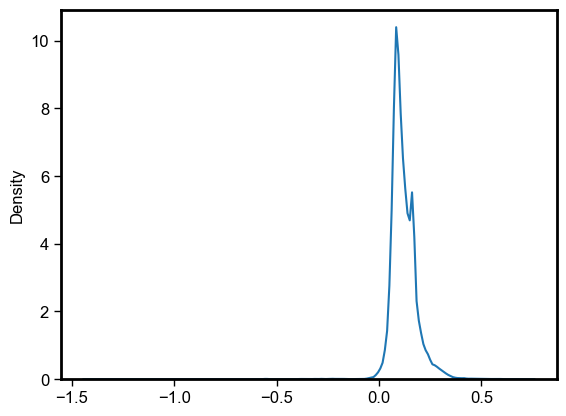

In [27]:
sns.kdeplot(trend3.to_numpy().flatten())

In [28]:
x, y = np.meshgrid(best_smooth.lon, best_smooth.lat)

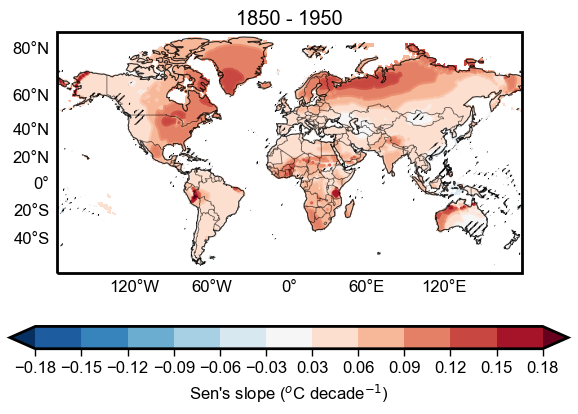

In [122]:
plt.figure(figsize=(6,7))
ax = plt.axes(projection=ccrs.Miller())
lvls = [-0.18, -0.15, -0.12, -0.09, -0.06, -0.03, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18]
ax.set_extent([-180, 180, -60, 85])
# trend1_land.plot(cmap='RdBu_r', vmin=-0.18, extend='both', transform=ccrs.PlateCarree(), cbar_kwargs=dict(orientation='horizontal', shrink=0.7, pad=0.10, label = "Sen's slope ($^{o}$C decade$^{-1}$)"))
trend1_land.plot.contourf(cmap='RdBu_r', levels = lvls, extend='both', transform=ccrs.PlateCarree(), \
                          cbar_kwargs=dict(orientation='horizontal', shrink=1.2, aspect=25, pad=0.1, label = "Sen's slope ($^{o}$C decade$^{-1}$)", ticks=lvls))
trend1_land.plot.contour(cmap='RdBu_r', levels= lvls, extend='both', transform=ccrs.PlateCarree())
z = np.ma.masked_less(trend1_pval_land, 0.05)
plt.pcolor(x, y, z, hatch='/////', alpha=0., lw=0.5, transform=ccrs.PlateCarree())
# plt.scatter(x[pval100 < 0.6], y[pval100 < 0.6], marker='.', transform=ccrs.PlateCarree(), s=1, color='k')
ax.add_feature(cfeature.COASTLINE, lw=0.8, alpha=0.8, zorder=2)
# ax.add_feature(cfeature.OCEAN, color='white', zorder=1)
ax.add_feature(cfeature.BORDERS, lw=0.6, alpha=0.6, zorder=3)
gl = ax.gridlines(draw_labels=True, alpha=0.)
gl.top_labels = False
gl.right_labels = False
ax.set_title('1850 - 1950')
plt.savefig('./images/trends/trend1_land.png', dpi=300, bbox_inches = 'tight')

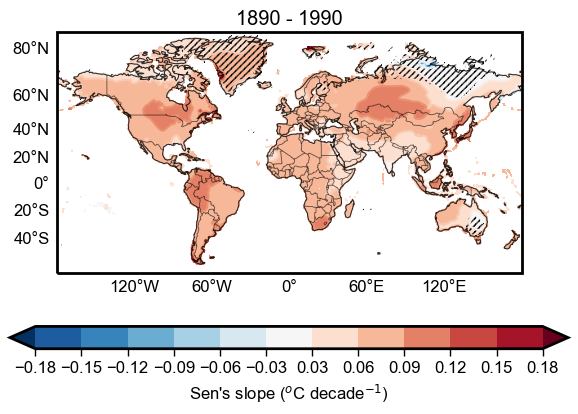

In [123]:
plt.figure(figsize=(6,7))
ax = plt.axes(projection=ccrs.Miller())
lvls = [-0.18, -0.15, -0.12, -0.09, -0.06, -0.03, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18]
ax.set_extent([-180, 180, -60, 85])
# trend1_land.plot(cmap='RdBu_r', vmin=-0.18, extend='both', transform=ccrs.PlateCarree(), cbar_kwargs=dict(orientation='horizontal', shrink=0.7, pad=0.10, label = "Sen's slope ($^{o}$C decade$^{-1}$)"))
trend2_land.plot.contourf(cmap='RdBu_r', levels = lvls, extend='both', transform=ccrs.PlateCarree(), \
                          cbar_kwargs=dict(orientation='horizontal', shrink=1.2, aspect=25, pad=0.1, label = "Sen's slope ($^{o}$C decade$^{-1}$)", ticks=lvls))
trend2_land.plot.contour(cmap='RdBu_r', levels= lvls, extend='both', transform=ccrs.PlateCarree())
z = np.ma.masked_less(trend2_pval_land, 0.05)
plt.pcolor(x, y, z, hatch='/////', alpha=0., lw=0.5, transform=ccrs.PlateCarree())
# plt.scatter(x[pval100 < 0.6], y[pval100 < 0.6], marker='.', transform=ccrs.PlateCarree(), s=1, color='k')
ax.add_feature(cfeature.COASTLINE, lw=0.8, alpha=0.8, zorder=2)
# ax.add_feature(cfeature.OCEAN, color='white', zorder=1)
ax.add_feature(cfeature.BORDERS, lw=0.6, alpha=0.6, zorder=3)
gl = ax.gridlines(draw_labels=True, alpha=0.)
gl.top_labels = False
gl.right_labels = False
ax.set_title('1890 - 1990')
plt.savefig('./images/trends/trend2_land.png', dpi=300, bbox_inches = 'tight')

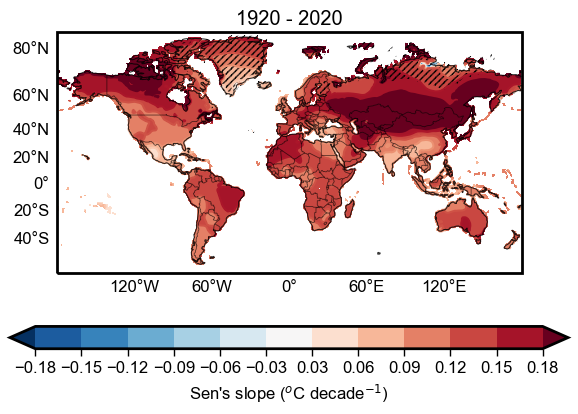

In [124]:
plt.figure(figsize=(6,7))
ax = plt.axes(projection=ccrs.Miller())
lvls = [-0.18, -0.15, -0.12, -0.09, -0.06, -0.03, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18]
ax.set_extent([-180, 180, -60, 85])
# trend1_land.plot(cmap='RdBu_r', vmin=-0.18, extend='both', transform=ccrs.PlateCarree(), cbar_kwargs=dict(orientation='horizontal', shrink=0.7, pad=0.10, label = "Sen's slope ($^{o}$C decade$^{-1}$)"))
trend3_land.plot.contourf(cmap='RdBu_r', levels = lvls, extend='both', transform=ccrs.PlateCarree(), \
                          cbar_kwargs=dict(orientation='horizontal', shrink=1.2, aspect=25, pad=0.1, label = "Sen's slope ($^{o}$C decade$^{-1}$)", ticks=lvls))
trend3_land.plot.contour(cmap='RdBu_r', levels= lvls, extend='both', transform=ccrs.PlateCarree())
z = np.ma.masked_less(trend3_pval_land, 0.05)
plt.pcolor(x, y, z, hatch='/////', alpha=0., lw=0.5, transform=ccrs.PlateCarree())
# plt.scatter(x[pval100 < 0.6], y[pval100 < 0.6], marker='.', transform=ccrs.PlateCarree(), s=1, color='k')
ax.add_feature(cfeature.COASTLINE, lw=0.8, alpha=0.8, zorder=2)
# ax.add_feature(cfeature.OCEAN, color='white', zorder=1)
ax.add_feature(cfeature.BORDERS, lw=0.6, alpha=0.6, zorder=3)
gl = ax.gridlines(draw_labels=True, alpha=0.)
gl.top_labels = False
gl.right_labels = False
ax.set_title('1920 - 2020')
plt.savefig('./images/trends/trend3_land.png', dpi=300, bbox_inches = 'tight')

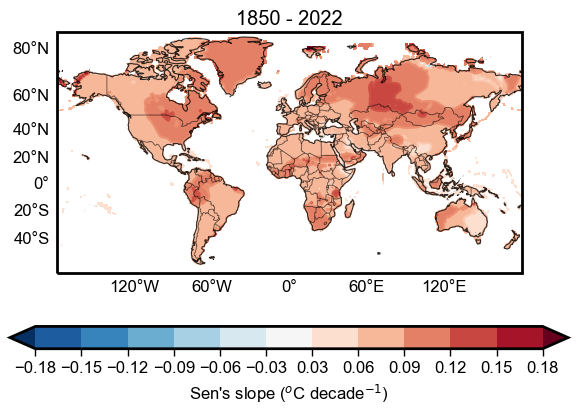

In [129]:
plt.figure(figsize=(6,7))
ax = plt.axes(projection=ccrs.Miller())
lvls = [-0.18, -0.15, -0.12, -0.09, -0.06, -0.03, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18]
ax.set_extent([-180, 180, -60, 85])
# trend1_land.plot(cmap='RdBu_r', vmin=-0.18, extend='both', transform=ccrs.PlateCarree(), cbar_kwargs=dict(orientation='horizontal', shrink=0.7, pad=0.10, label = "Sen's slope ($^{o}$C decade$^{-1}$)"))
trend4_land.plot.contourf(cmap='RdBu_r', levels = lvls, extend='both', transform=ccrs.PlateCarree(), \
                          cbar_kwargs=dict(orientation='horizontal', shrink=1.2, aspect=25, pad=0.1, label = "Sen's slope ($^{o}$C decade$^{-1}$)", ticks=lvls))
trend4_land.plot.contour(cmap='RdBu_r', levels= lvls, extend='both', transform=ccrs.PlateCarree())
z = np.ma.masked_less(trend4_pval_land, 0.05)
plt.pcolor(x, y, z, hatch='/////', alpha=0., lw=0.5, transform=ccrs.PlateCarree())
# plt.scatter(x[pval100 < 0.6], y[pval100 < 0.6], marker='.', transform=ccrs.PlateCarree(), s=1, color='k')
ax.add_feature(cfeature.COASTLINE, lw=0.8, alpha=0.8, zorder=2)
# ax.add_feature(cfeature.OCEAN, color='white', zorde1=2)
ax.add_feature(cfeature.BORDERS, lw=0.6, alpha=0.6, zorder=3)
gl = ax.gridlines(draw_labels=True, alpha=0.)
gl.top_labels = False
gl.right_labels = False
ax.set_title('1850 - 2022')
plt.savefig('./images/trends/trend4_land.png', dpi=300, bbox_inches = 'tight')